<a href="https://colab.research.google.com/github/WilderGitHub/datascience/blob/main/NB_BoW_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with Naïve Bayes.
**Objetivo**. Que el estudiante aprenda a representar documentos de forma básica y construir un clasificador probabilista para abordar el problema.

Trabajaremos con un conjunto de textos estándar. Primero especificar las librerias que serán de utilidad

In [ ]:
## Primero se importan algunas librerias de utilidad
#import random
import re # regular expression
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.metrics import classification_report


# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

Carguemos la base de datos ( en caso de que no esté en nuestro path, se descarga directamente de internet)

In [ ]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

print('Éstas son algunas muestras de la BD, con su respectiva etiqueta')
df = pd.read_csv(DATA_PATH)
df.sample(10)



In [ ]:
# construyamos la bolsa de palabras
# si no tenemos muchos recursos se puede hacer solo para una muestra de los documentos
# ndocs=10000

from sklearn.feature_extraction.text import CountVectorizer
# Construye bolsa de palabras con pesado booleano, y parámetros por default
count_vect = CountVectorizer(binary=True)
X_train_counts = count_vect.fit_transform(df.review)
Ytrain=y=df.label
#X_train_counts = count_vect.fit_transform(df.review(:ndocs))
#Ytrain=y=df.label(:ndocs)
print(X_train_counts.shape)
ndocs=X_train_counts.shape[0]

(62155, 103740)


In [ ]:
# se imprime el conjunto de clases
class_set=np.unique(Ytrain)
print(class_set)

[0 1]


Fase de aprendizaje del clasificador NB

Se tienen  30870  ejemplos de la clase 1 y  31285  ejemplos de la clase -1
103740
Además, se tiene un vocabulario de  103740 términos
Las probabilidades a priori son:
[0.49666157 0.50333843]
[    0     1     2 ... 62151 62152 62153]
(2, 103740)


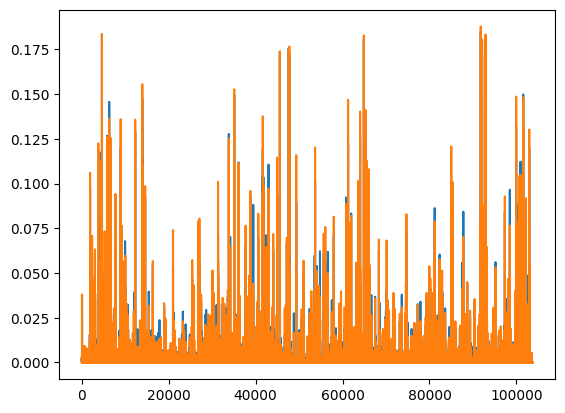

In [ ]:

# Separemos muestras positivas y negativas
# número de muestras positivas
npos=np.sum(Ytrain)
nsamples=len(Ytrain)
nneg=nsamples-npos
print('Se tienen ',npos,' ejemplos de la clase 1 y ',nneg,' ejemplos de la clase -1' )

nfeats=X_train_counts.shape[1]
print(nfeats)

print('Además, se tiene un vocabulario de ',nfeats, 'términos')

# Calculemos las probabilidades apriori
apriori=np.zeros((2))
apriori[0]= npos/nsamples
apriori[1]= nneg/nsamples

print('Las probabilidades a priori son:')
print(apriori)

# Ahora calculemos las condicionales (P(a_i | c))

# Calculemos el número de ocurrencias de cada atributo
allcounts=np.sum(X_train_counts,axis=0)

#print(X_train_counts.shape)

rel=np.array(np.where(Ytrain==1))
#print(rel[0])
aX=np.asmatrix(np.array(X_train_counts))
bX=aX[0,0]
p_samples=bX[rel[0]]
#print(p_samples)
s_pos= np.sum(bX[rel[0]],axis=0)

rel=np.array(np.where(Ytrain==0))
print(rel[0])
aX=np.asmatrix(np.array(X_train_counts))
bX=aX[0,0]
n_samples=bX[rel[0]]
#print(n_samples)
s_neg= np.sum(bX[rel[0]],axis=0)

pccounts=np.array([s_pos,s_neg])

P_AC=np.zeros((2,nfeats))
print(P_AC.shape)
for i in range(nfeats):
  for j in range(2):
    #i
    # esta parte calcula las condicionales
    P_AC[j,i] = (1+pccounts[j][0][i])/(allcounts[0,i]+nfeats)

# Grafiquemos las probabilidades
plt.plot(P_AC.T)


In [ ]:
# Ahora clasifiquemos un documento tomado del mismo dataset

idx=23932
ddoc = X_train_counts[idx,:]
A=ddoc.nonzero()
vv=A[1]

# se obtiene el vocabulario
V=count_vect.get_feature_names()
A=ddoc.nonzero()
wdoc = np.array(V)[vv.astype(int)]

print('Estas palabras aparecen en el documento:')
print(wdoc)
print('ahora en orden')
print(df.review[idx])



AttributeError: ignored

In [ ]:
# Ahora vamos a clasificar el documento anterior
# class_probs contiene las probabilidades de cada clase
class_probs=[0,0]
#class_probs[0]=np.log(apriori[0])
#class_probs[1]=np.log(apriori[1])
class_probs[0]=apriori[0]
class_probs[1]=apriori[1]

print('Probabilidades de cada clase a priori')
print(class_probs)

#print(nfeats)
#print(P_AC.shape)

for i in range(2):
  for j in range(nfeats):
    #class_probs[i]=class_probs[i]+(P_AC[i,j]*ddoc[0,j])
    #class_probs[i]=class_probs[i]+np.log((P_AC[i,j]*ddoc[0,j])+1e-2)
    class_probs[i]=class_probs[i]*(P_AC[i,j]*ddoc[0,j])
print('Probabilidades de cada clase a posteriori')
print(class_probs)

# Obtenemos la predicción
pred=np.argmax(class_probs)

print('La clase predicha es: ',class_set[pred],' la clase verdadera es ',Ytrain[idx])



Probabilidades de cada clase a priori
[0.4966615718767597, 0.5033384281232403]
Probabilidades de cada clase a posteriori
[0.0, 0.0]
La clase predicha es:  0  la clase verdadera es  1


Ahora clasifiquemos todos los documentos de entrenamiento

In [ ]:
# se obtiene el vocabulario
pred=np.zeros((ndocs,1))
#print(pred)
for idx in range(X_train_counts.shape[0]):
  ddoc = X_train_counts[idx,:]
  A=ddoc.nonzero()
  vv=A[1]


  print('Documento:')
  print(df.review[idx])

  class_probs=[0,0]
  #class_probs[0]=np.log(apriori[0])
  #class_probs[1]=np.log(apriori[1])
  print('Probabilidades de cada clase a priori')
  print(class_probs)
  for i in range(2):
    for j in range(nfeats):
      #class_probs[i]=class_probs[i]+np.log(((P_AC[i,j])*ddoc[0,j])+1e-3)
       class_probs[i]=class_probs[i]*(P_AC[i,j]*ddoc[0,j])

  print('Probabilidades de cada clase a posteriori')
  print(class_probs)

  # Obtenemos la predicción
  pred[idx]=np.argmax(class_probs)
  print('La clase predicha es: ',class_set[int(pred[idx])],' la clase verdadera es ',Ytrain[int(idx)])





Streaming output truncated to the last 5000 lines.
Probabilidades de cada clase a priori
[0, 0]
Probabilidades de cada clase a posteriori
[0.0, 0.0]
La clase predicha es:  0  la clase verdadera es  0
Documento:
Snakes on a Train is a movie I rented due to the pure amusement of the thoughts I had, about the movie. Snakes on a Plane was an enjoyable Action film, so obviously the film makers wanted to cash in on the success, with this low budget effort. At 85 minutes, Snakes on a Train is almost unbearable to witness. I had to keep pausing the film to do something to entertain myself, due to the lack of happenings in the film. Throughout the duration of the film, it's never fully explained why this girl has this curse, or why she keeps coughing up this green/purplish goo constantly. Not only that, there is endless boring dialog of the two main characters, Brujo and Alma discussing how to get rid of the curse. I can appreciate low budget film-making. I'm truly not picky on movies, i'm open

In [ ]:
# Alternativamente se puede calcular la representación term-frequency
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(62155, 103740)

In [ ]:
# y se puede construir un clasificador NB multinomial

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, Ytrain)
predicted = clf.predict(X_train_counts)

acc=(1-np.sum(np.abs(predicted-Ytrain))/len(Ytrain))*100
print('Training set accuracy is:',acc,'%')

#print(df.label)
#print(np.unique(df.label))

Training set accuracy is: 89.91231598423298 %
